# Statistical Analysis of Parking & QOL Data


The following is the statistical analysis used to help determine if there is a correlation between parking and quality of life (QOL) in cities. QOL indices from [Numbeo](https://www.numbeo.com/quality-of-life/) were matched against parking data from [OpenStreetMap](https://www.openstreetmap.org/). Using the Overpass API, over 600,000 data points were examined from 250+ global cities. Data was cleaned and tested using a variety of Python libraries, including **Pandas**, **GeoPy**, and **OverPy**. **SciKit-Learn** was then used to determine a statistically significant correlation between parking and QOL. <em>To read the full report, please contact me through email as found on my portfolio at **http://juaneslamilla.github.io**.</em>

### Background Information:

Minimum parking requirements are regulations that mandate a certain minimum number of parking spaces for public and private developments. These requirements have led to an expanse of free parking across North America, but recent findings indicate that this can cause urban quality of life to suffer. An article from Bloomberg discusses how parking spaces from minimum parking requirements can degrade quality of life (Goodyear, 2014). Alexandri et al. (2020) argue that free parking “discourages environmentally-friendly and healthier transit” and that “on-street parking has been found responsible for large amounts of energy waste, CO2 emissions, contributions to congested traffic, as well as time waste”. The issues with free parking and minimum parking requirements have been known for some time and may be responsible for an increase in the price of all goods sold at sites that offer free parking due to the high value of the land they take up (Shoup, 1999). Shoup (2011) has gone on to argue that free parking has “contributed to auto dependence, rapid urban sprawl, extravagant energy use, and a host of other problems”. This has led Canadian cities such as Edmonton, Alberta and Kingston, Ontario to remove minimum parking requirements in recent years (Cummings, 2022; Wilson et al., 2022). This being the case, I want to better understand if there is a statistically significant connection between parking and quality of life as this information may be useful for urban planners and government officials. The World Health Organization (n.d.) defines Quality of Life as “as an individual's perception of their position in life in the context of the culture and value systems in which they live and in relation to their goals, expectations, standards and concerns”. Moro et al. (2008) point out how quality of life indices have a long tradition in hedonic literature. As such, quality of life rankings are regularly posted by various magazines and consulting groups. Although their criteria often differs, they offer an insight into how quality of life may be measured. Overall, exploring the relationship between parking and quality of life is important for understanding how parking regulations can affect the well-being of individuals living in urban areas.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore

import ipywidgets as widgets
from IPython.display import display

## Loading the Data

Data was collected using the code found in the other files in this github repository. Since data was scraped from OpenStreetMap, there were outliers that were likely caused due to insufficient OSM data representing real life conditions. These were manually removed. Furthermore, in order to (somewhat) fullfill the assumptions neccessary for a linear regression model, the positively skewed parking data was transformed using a log10 function and data outside the second standard deviation was removed.

In [2]:
# Load Data
data = pd.read_csv('Cities_QOL.csv')
data["Total_Parking_Area"] = data["Total_Parking_Area"] + (data["Park_Nodes"] * 3000) # Account for OSM parking data types
data["Parking_Over_Pop"] = data["Total_Parking_Area"] / (data["Total_Contributors"] / data["Population"]) # Normalize based on city population & number of OSM contributors 
data = data.rename(columns={"Quality of Life Index": "Quality_of_Life_Index"})

# Remove Outliers
data = data[data['Total_Parking_Area'] > 200000]
data["Parking_Over_Pop"] = np.log10(data["Parking_Over_Pop"])
data = data[np.abs(zscore(data["Parking_Over_Pop"])) < 2]

## Limit Analysis by Area

The following widgets were created to so one can easily rerun the analysis, but for specific continents/regions. 
E.g. North America & Europe, Southern & Eastern Africa, etc

In [3]:
select_continent = widgets.SelectMultiple(
    options=list(data['Continent'].unique()),
    value=list(data['Continent'].unique()),
    #rows=10,
    description='Continent(s)',
    disabled=False
)
display(select_continent)

SelectMultiple(description='Continent(s)', index=(0, 1, 2, 3, 4, 5), options=('Asia', 'Europe', 'North America…

In [4]:
data = data.loc[data["Continent"].isin(select_continent.value)]

In [5]:
select_region = widgets.SelectMultiple(
    options=list(data['Region 1'].unique()),
    value=list(data['Region 1'].unique()),
    #rows=10,
    description='Region(s)',
    disabled=False
)

display(select_region)

SelectMultiple(description='Region(s)', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17), …

In [6]:
data = data.loc[data["Region 1"].isin(select_region.value)]

With the data collected, cleaned, and formatted, we can begin the analysis.

In [7]:
data.head()

,City,Quality_of_Life_Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index,...,Total_Parking_Area,Park_Ways,Park_Nodes,Park_Relations,Continent,Region 1,Region 2,Total_Contributors,Country_Population,Parking_Over_Pop
1,Chennai,113.0,61.8,60.1,70.0,22.8,12.0,47.3,74.3,53.2,...,2.508276e+05,65,42,2,Asia,Southern Asia,NaN,275801.0,1.407564e+09,7.021888
3,Copenhagen,185.7,89.4,73.6,77.7,82.4,9.3,28.4,21.2,83.7,...,1.946127e+06,2257,121,8,Europe,Northern Europe,NaN,95791.0,5.856733e+06,7.343276
4,Taipei,149.0,74.8,84.8,86.4,57.2,30.0,34.7,49.5,84.4,...,2.944667e+06,1083,283,32,Asia,South-eastern Asia,NaN,65329.0,2.356838e+07,8.082804
8,Hyderabad,119.4,56.6,57.1,65.1,25.3,8.1,42.1,76.0,73.5,...,2.512255e+05,44,40,0,Asia,Southern Asia,NaN,275801.0,1.407564e+09,6.198189
9,Gurgaon,111.3,84.0,45.1,60.2,27.5,6.7,36.7,91.5,59.9,...,9.538218e+05,73,35,0,Asia,Southern Asia,NaN,275801.0,1.407564e+09,5.834087


## Linear Regression Model

The following code creates the linear regression model with QOL being the dependant variable, and parking (normalized for population) as the independant. 

In [8]:
model = smf.ols(formula='Quality_of_Life_Index ~ Parking_Over_Pop', data= data )
results = model.fit()
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     Quality_of_Life_Index   R-squared:                       0.206
Model:                               OLS   Adj. R-squared:                  0.202
Method:                    Least Squares   F-statistic:                     59.26
Date:                   Sun, 02 Jul 2023   Prob (F-statistic):           4.11e-13
Time:                           21:39:35   Log-Likelihood:                -1119.6
No. Observations:                    231   AIC:                             2243.
Df Residuals:                        229   BIC:                             2250.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

## Linear Regression Assumptions Diagnostics

The following plots were created to diagnose the linear regression assumptions of linearity, normality, and homoscedasticity. We are already assuming parking quantity and quality of life are independent variables.

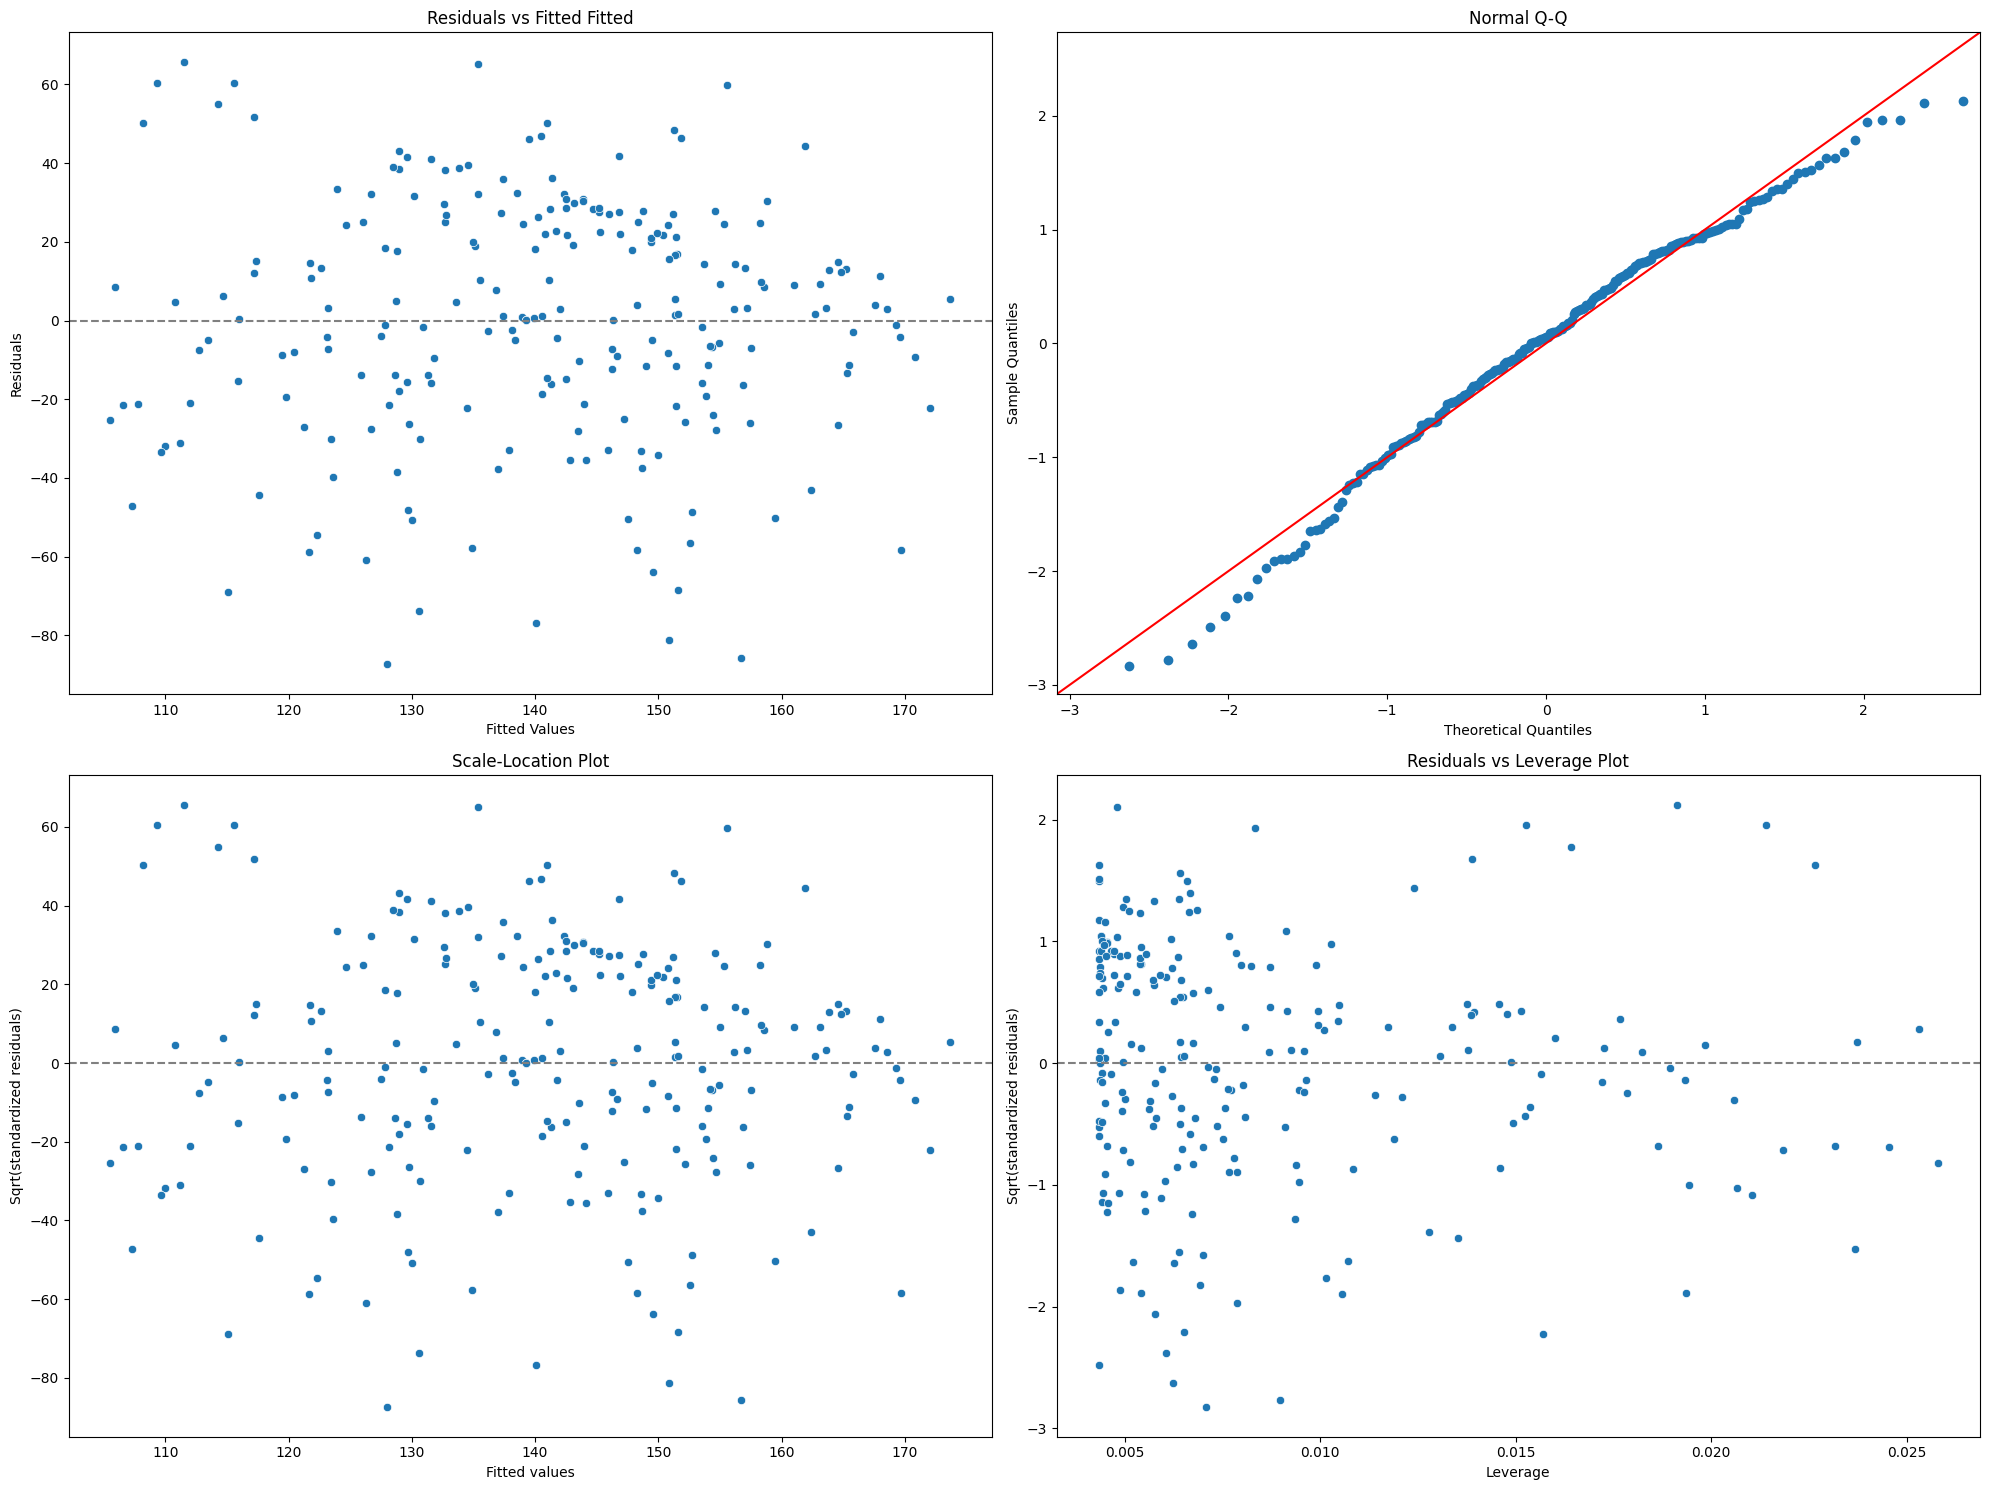

In [9]:
# Get different Variables for diagnostic
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag

# PLot different diagnostic plots
plt.rcParams["figure.figsize"] = (20,15)
fig, ax = plt.subplots(nrows=2, ncols=2)


# Residual vs Fitted Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[0, 0])
ax[0, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[0, 0].set_xlabel('Fitted Values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted Fitted')


# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line='45',ax=ax[0, 1])
ax[0, 1].set_title('Normal Q-Q')

# Scale-Location Plot
sns.scatterplot(x=fitted_value, y=residuals, ax=ax[1, 0])
ax[1, 0].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('Sqrt(standardized residuals)')
ax[1, 0].set_title('Scale-Location Plot')

# Residual vs Leverage Plot
sns.scatterplot(x=leverage, y=stand_resids, ax=ax[1, 1])
ax[1, 1].axhline(y=0, color='grey', linestyle='dashed')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Sqrt(standardized residuals)')
ax[1, 1].set_title('Residuals vs Leverage Plot')


plt.tight_layout()

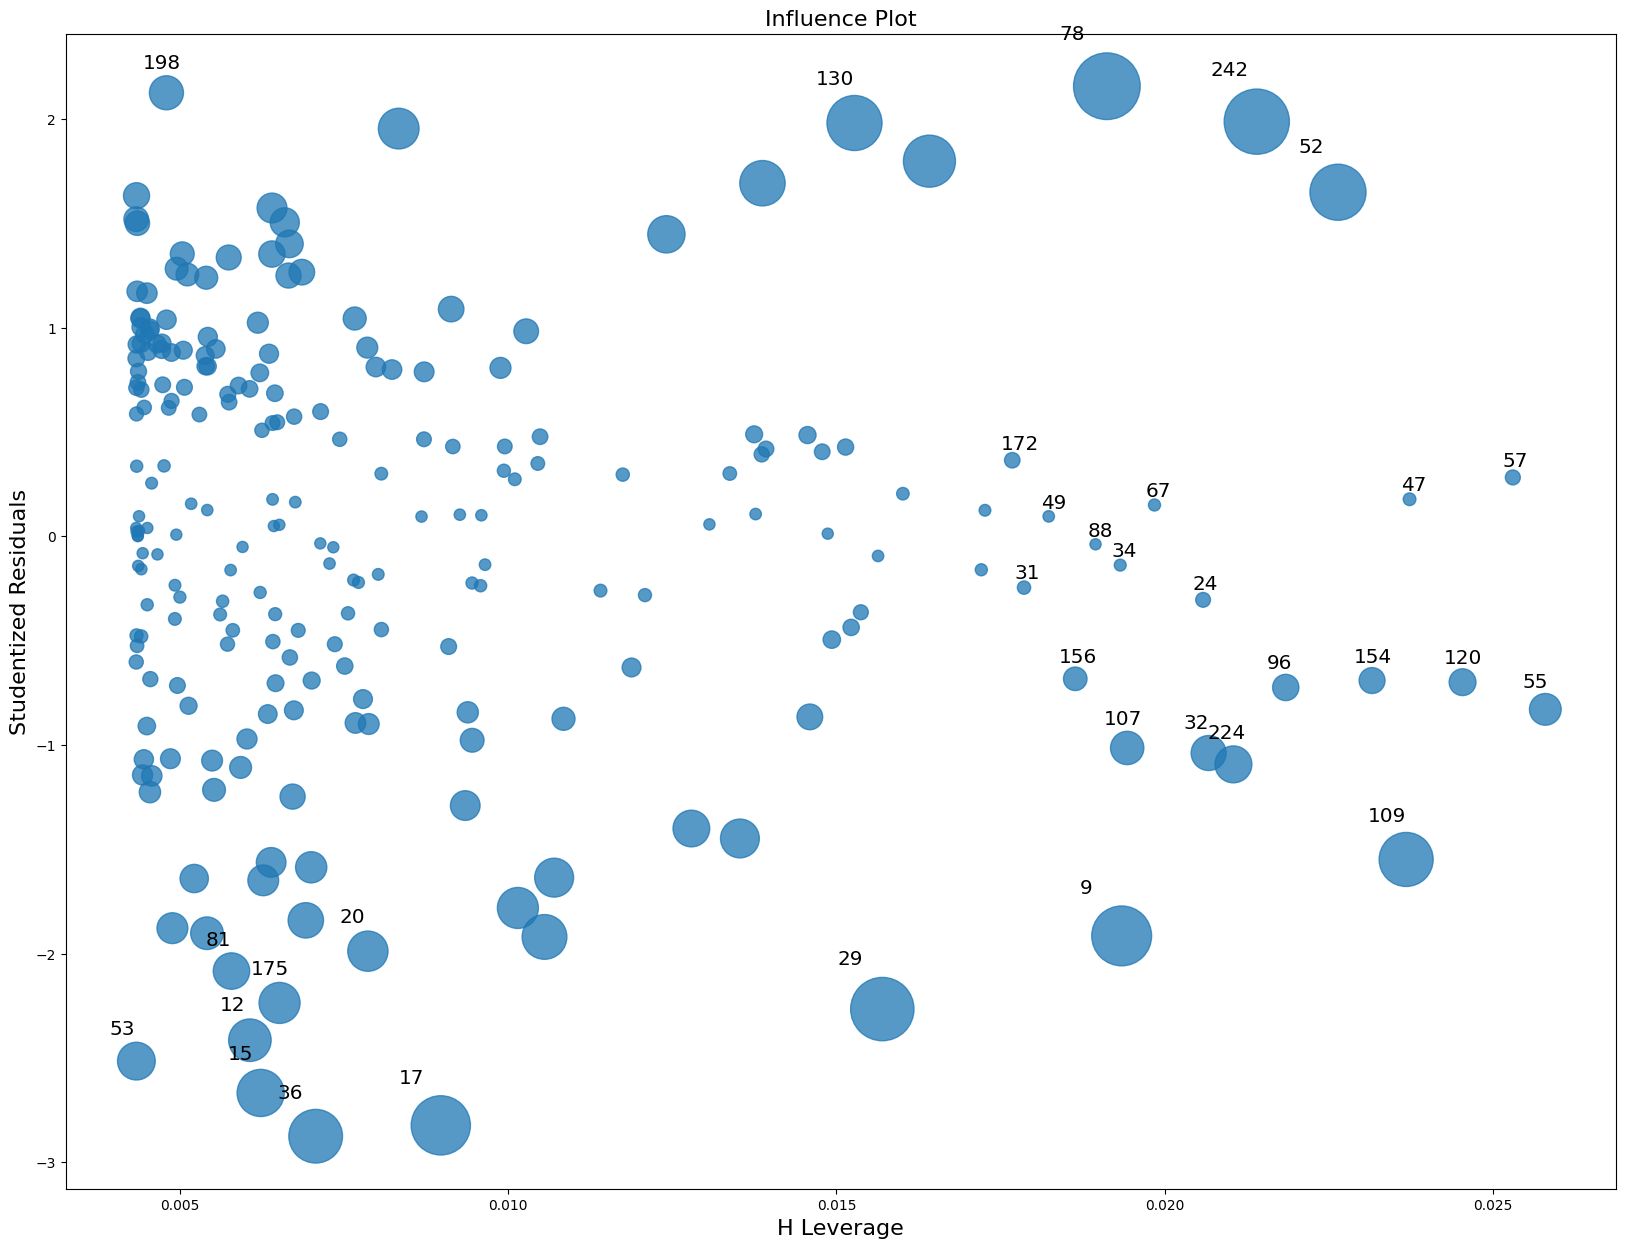

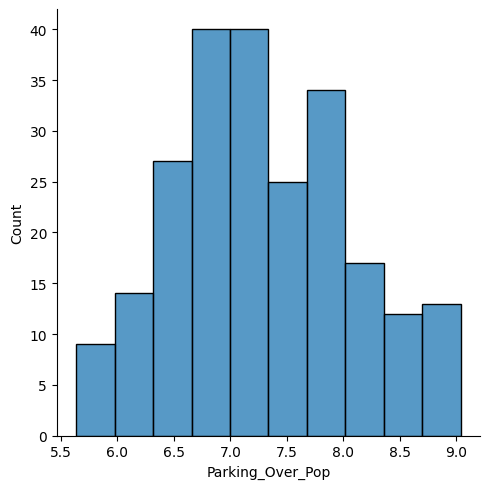

In [10]:
# Plot Cook's distance plot
sm.graphics.influence_plot(results, criterion="cooks")

sns.displot(data["Parking_Over_Pop"])
plt.show()

## Correlation Coefficients

Due to the nature of the data and how we've cleaned it, we can expect the Pearson, Spearman, and Kendall's correlation coefficients to have similar values.

In [11]:
pearson_corr, pearson_pval = pearsonr(data['Quality_of_Life_Index'], data['Parking_Over_Pop'])
print(f"Pearson correlation coefficient: {pearson_corr:.3f}")
print(f"Pearson p-value: {pearson_pval:.3f}")

# Compute Spearman rank correlation coefficient and p-value
spearman_corr, spearman_pval = spearmanr(data['Quality_of_Life_Index'], data['Parking_Over_Pop'])
print(f"Spearman rank correlation coefficient: {spearman_corr:.3f}")
print(f"Spearman p-value: {spearman_pval:.3f}")

# Compute Kendall's tau correlation coefficient and p-value
kendall_corr, kendall_pval = kendalltau(data['Quality_of_Life_Index'], data['Parking_Over_Pop'])
print(f"Kendall's tau correlation coefficient: {kendall_corr:.3f}")
print(f"Kendall's tau p-value: {kendall_pval:.3f}")

Pearson correlation coefficient: -0.453
Pearson p-value: 0.000
Spearman rank correlation coefficient: -0.428
Spearman p-value: 0.000
Kendall's tau correlation coefficient: -0.296
Kendall's tau p-value: 0.000


## Correlation Heatmap (with other Indices)

By scraping our quality of life data from Numbeo, we've also collected other living indices. We can then compare them to our parking data. 

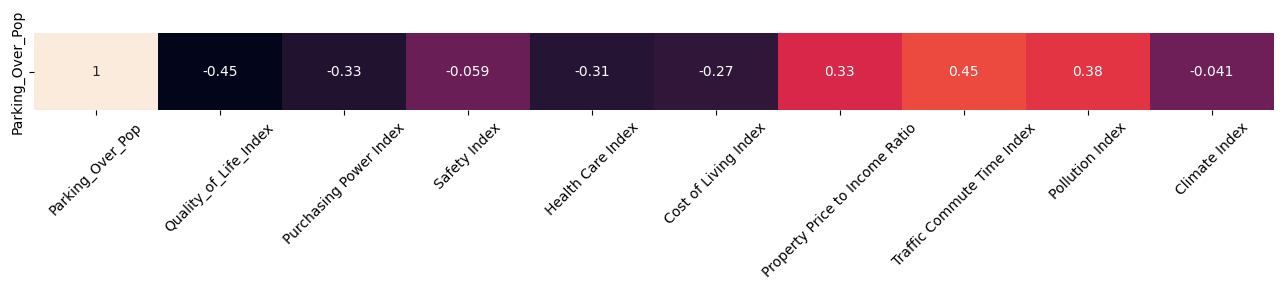

In [12]:
data_heatmap = data.loc[:, ["Parking_Over_Pop", 'Quality_of_Life_Index', 'Purchasing Power Index', 'Safety Index', 'Health Care Index', 'Cost of Living Index', 'Property Price to Income Ratio', 'Traffic Commute Time Index', 'Pollution Index', 'Climate Index']]

corr_matrix = data_heatmap.corr()
plt.figure(figsize = (16,1))
sns.heatmap(corr_matrix[0:1], annot=True, cbar=False)
plt.xticks(rotation=45)
plt.show()

## References

Alexandri, E., & Lampropoulos, A. (2020). Which is the optimum option for parking in the city centre? IOP Conference Series: Earth and Environmental Science, 410(1), 012052. https://doi.org/10.1088/1755-1315/410/1/012052

Cummings, M. (2022, December 12). Edmonton got rid of parking minimums 2 years ago. what has happened since then? | CBC news. CBCnews. Retrieved January 16, 2023, from https://www.cbc.ca/news/canada/edmonton/edmonton-got-rid-of-parking-minimums-2-years-ago-what-has-happened-since-then-1.6680750#:~:text=In%20June%20of%202020%2C%20Edmonton,decide%20how%20much%20to%20offer.

Goodyear, S. (2014, July 14). How parking spaces are eating our cities alive. Bloomberg.com. Retrieved January 16, 2023, from https://www.bloomberg.com/news/articles/2014-07-14/how-parking-spaces-are-eating-our-cities-alive

Hvistendahl, M. (2013). Foreigners run afoul of China's tightening secrecy rules. Science, 339(6118), 384–385. https://doi.org/10.1126/science.339.6118.384

Moro, M., Brereton, F., Ferreira, S., & Clinch, J. P. (2008). Ranking quality of life using subjective well-being data. Ecological Economics, 65(3), 448–460. https://doi.org/10.1016/j.ecolecon.2008.01.003

Numbeo. (2017). Quality of Life. Cost of Living. Retrieved March 27, 2023, from https://www.numbeo.com/quality-of-life/indices_explained.jsp

OpenStreetMap. (n.d.). OpenStreetMap About Page. OpenStreetMap. Retrieved March 27, 2023, from https://www.openstreetmap.org/about

Pucher, J., & Lefèvre, C. (1996). The United States: The CAR-dependent society. The Urban Transport Crisis in Europe and North America, 175–200. https://doi.org/10.1057/9780230371835_10

Shoup, D. C. (1999). The trouble with minimum parking requirements. Transportation Research Part A: Policy and Practice, 33(7-8), 549–574. https://doi.org/10.1016/s0965-8564(99)00007-5

Shoup, D. C. (2011). The high cost of Free Parking. Routledge.

Sohn, K., & Yun, J. (2009). Separation of car-dependent commuters from normal-choice riders in mode-choice analysis. Transportation, 36(4), 423–436. https://doi.org/10.1007/s11116-009-9209-9

Wilson, K., Cuba, J., Schmitt, A., & Varone, J. (2022, May 9). Steal this idea: Canadian city passes next-Gen Parking Reform. Streetsblog USA. Retrieved January 16, 2023, from https://usa.streetsblog.org/2022/05/09/steal-this-idea-canadian-town-passes-next-gen-parking-reform/?mc_cid=094fae6540&mc_eid=c2cf50b18d

World Health Organization. (n.d.). WHOQOL - measuring quality of life| The World Health Organization. World Health Organization. Retrieved February 7, 2023, from https://www.who.int/tools/whoqol

Yin, C., Shao, C., & Wang, X. (2018). Built environment and parking availability: Impacts on car ownership and use. Sustainability, 10(7), 2285. https://doi.org/10.3390/su10072285 
